# ノート 5: 人工ニューラルネットワーク（ANN）の学習

### 目標: 人工ニューラルネットワークの学習と評価を行う

### 背景

論文の解説と同じように ANN の学習から始めましょう。
学習済みモデルもレポジトリに登録してありますが、このノートで ANN のモデル学習を自分で行ってみましょう。


### Step 1: インポート


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # 不要な警告の抑止

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

print(f"NumPy  : {np.__version__}")
print(f"Pandas : {pd.__version__}")
print(f"PyTorch: {torch.__version__}")

# 再現性のため乱数を固定
_ = torch.manual_seed(42)

# jupyterのカスタマイズ
%config InlineBackend.figure_format = 'retina'

NumPy  : 1.26.3
Pandas : 2.2.0
PyTorch: 2.1.2+cpu


### Step 2: データの読み込み

sub-SEVIR データセットのパーセンタイル値と分類問題のラベルを読み込みます。特徴量は正規化してあります。


In [2]:
from pathlib import Path


save_dir = Path("../datasets/sub-sevir-engineered")
df_t = pd.read_csv(save_dir / "lowres_features_train.csv")
df_v = pd.read_csv(save_dir / "lowres_features_val.csv")

# PyTorchで扱うためにテンソルに変換しておく
# 特徴量: (, 36)
X_t = torch.FloatTensor(df_t.iloc[:, :36].to_numpy())
X_v = torch.FloatTensor(df_v.iloc[:, :36].to_numpy())
# ラベル（発雷の有無）: (, 1)
y_t = torch.FloatTensor(df_t.iloc[:, 36].to_numpy())
y_v = torch.FloatTensor(df_v.iloc[:, 36].to_numpy())

### Step 3: データセットの作成

ミニバッチでの学習を効率よくコーディングするため `Dataset` と `DataLoader` を利用します。


In [3]:
from torch.utils.data import DataLoader, TensorDataset


train_ds = TensorDataset(X_t, y_t)
valid_ds = TensorDataset(X_v, y_v)

# 訓練データのみシャッフルする
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)

`DataLoader` のコンストラクタでバッチサイズを指定します。
バッチサイズが小さすぎるとモデルの学習の反復計算のコストが大きくなります。一方で、バッチサイズが大きすぎるとメモリ消費が大きくなってしまいます。
バッチサイズは計算を行うマシンに依存します。


### Step 4: モデルの構築

ニューラルネットワークはデフォルトのパラメータの組み合わせでよい結果が得られる
「one size fits all（=どんな場合にもうまくいく）」な革新的な方法ではありません。
ニューラルネットワークでも適切なハイパーパラメータを **探す必要があります**。
ここで使うモデル構築はあくまで一例なので様々なモデル構成を試して遊びながら
与えられた予測問題に最適なハイパーパラメータを見つける練習をしてみることをお勧めします。


#### （注）カーネルの初期化

PyTorch の各層のモデルの重みはデフォルトのサンプリング法でランダムに初期化されていますが Tensorflow/Keras を使っている元論文と同じ方法ではうまく学習が進みませんでした。
このため、元論文をなるべく再現するためにカーネルとバイアスの重みを Keras のデフォルト値と同じ手法（
重みは Glorot initialization（Glorot and Bengio, 2010）、バイアスはゼロ）で初期化しなおします。

- [kernel_initializer って学習の収束に大事かも | GoodyPress](https://goody-jp.com/kernel_initializerって学習の収束に大事かも/)
- [CrossEntropyLoss - Expected object of type torch.LongTensor - vision - PyTorch Forums](https://discuss.pytorch.org/t/crossentropyloss-expected-object-of-type-torch-longtensor/28683/5)
- [tf.keras.initializers.GlorotUniform  |  TensorFlow v2.15.0.post1](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)
- [torch.nn.init — PyTorch 2.2 documentation](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_)

この後でも使えるように重みを初期化するための関数を定義しておきます。
モデルの構造だけではなく、パラメータの初期値やハイパーパラメータがモデル性能に影響する例ともいえます。


In [4]:
def init_weights(m: nn.Module) -> None:
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias = nn.init.zeros_(m.bias)

まずは、シンプルに 2 つのニューロンを持つ 2 層のモデルを作成し
データに雷が含まれているか（=0）、含まれていないか（=1）を分類してみましょう。


In [5]:
model = nn.Sequential(
            # 入力層
            nn.Linear(in_features=36, out_features=2),  # 入力36、出力2
            nn.ReLU(),
            # 中間層
            nn.Linear(in_features=2, out_features=2),  # 入力2、出力2
            nn.ReLU(),
            # 出力層
            nn.Linear(in_features=2, out_features=1),  # 入力2、出力1
            nn.Sigmoid(),
        )
# 重みを初期化
for m in model:
    init_weights(m)

`torchinfo` を使って詳細を見てみましょう。


In [6]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            74
├─ReLU: 1-2                              --
├─Linear: 1-3                            6
├─ReLU: 1-4                              --
├─Linear: 1-5                            3
├─Sigmoid: 1-6                           --
Total params: 83
Trainable params: 83
Non-trainable params: 0

- PyTorch では各層で入力、出力の形状を指定しておく必要があります。このモデル構築では `nn.Linear` の引数が該当します。
- 入力層と中間層には活性化関数が含まれています。活性化関数はニューラルネットワークが非線形な関係を学習するために必要で ReLU 関数はよくつかわれる活性化関数です。
- 出力層ではシグモイド関数を活性化関数にしています。
  - シグモイド関数は取り扱う問題が分類問題のため出力を 0-1 の範囲の確率値とするために使用します（非線形な活性化関数ではありません）。
    回帰問題の場合は必要ありません。
  - 3 値以上の分類問題（例えば、雷なし、雷あり、雷が多いの分類）の場合はシグモイド関数ではなくソフトマックス関数を用います。


### Step 5: 初期化状態での実行

学習前のモデルは重みパラメータとバイアスがランダムに初期化された状態です。
初期状態でのモデルの出力を可視化してみます。


(0.0, 1.0)

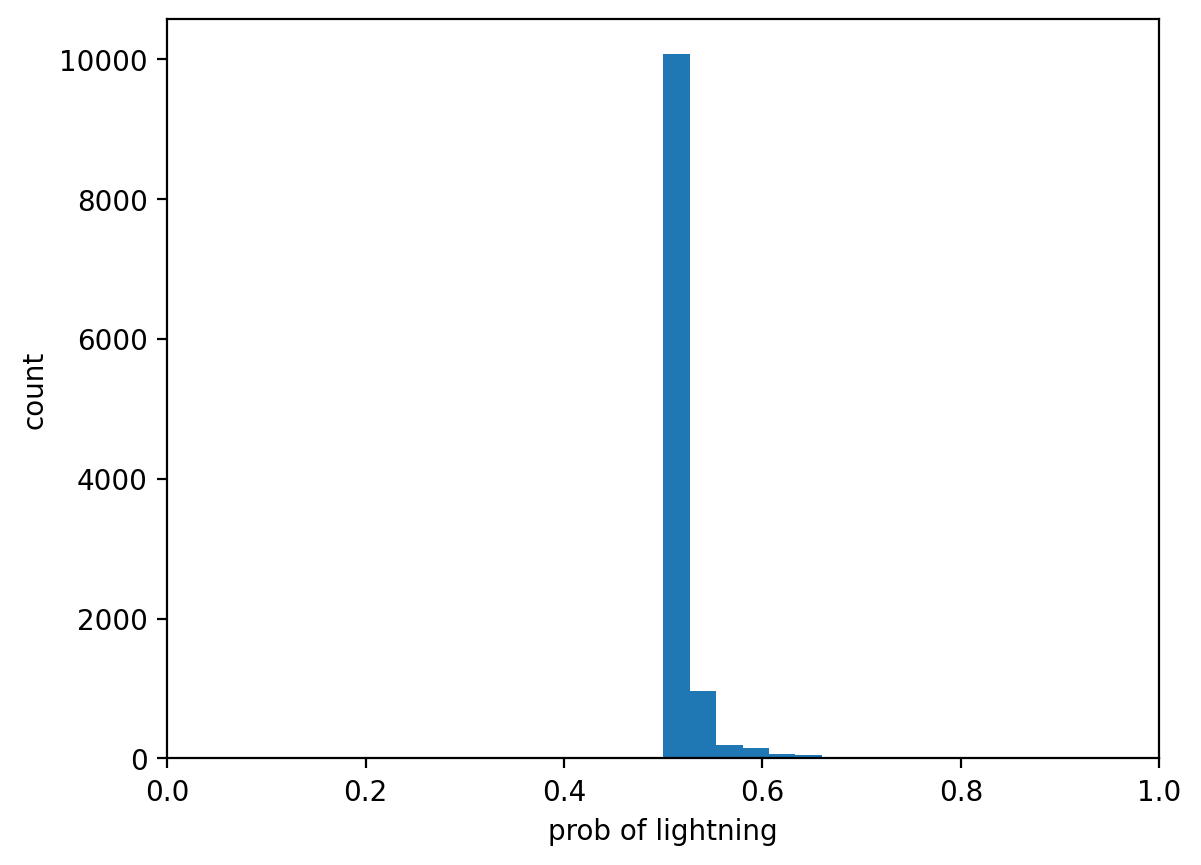

In [7]:
model.eval()
with torch.no_grad():
    y_preds = torch.cat([model(xb) for xb, _ in valid_dl]).numpy()

plt.hist(y_preds[:,0])
plt.xlabel("prob of lightning")
plt.ylabel("count")
plt.xlim([0, 1])

出力層のシグモイド関数により出力は 0-1 の範囲になっています。パフォーマンスダイアグラムもプロットします。


求めた指標でプロットします。


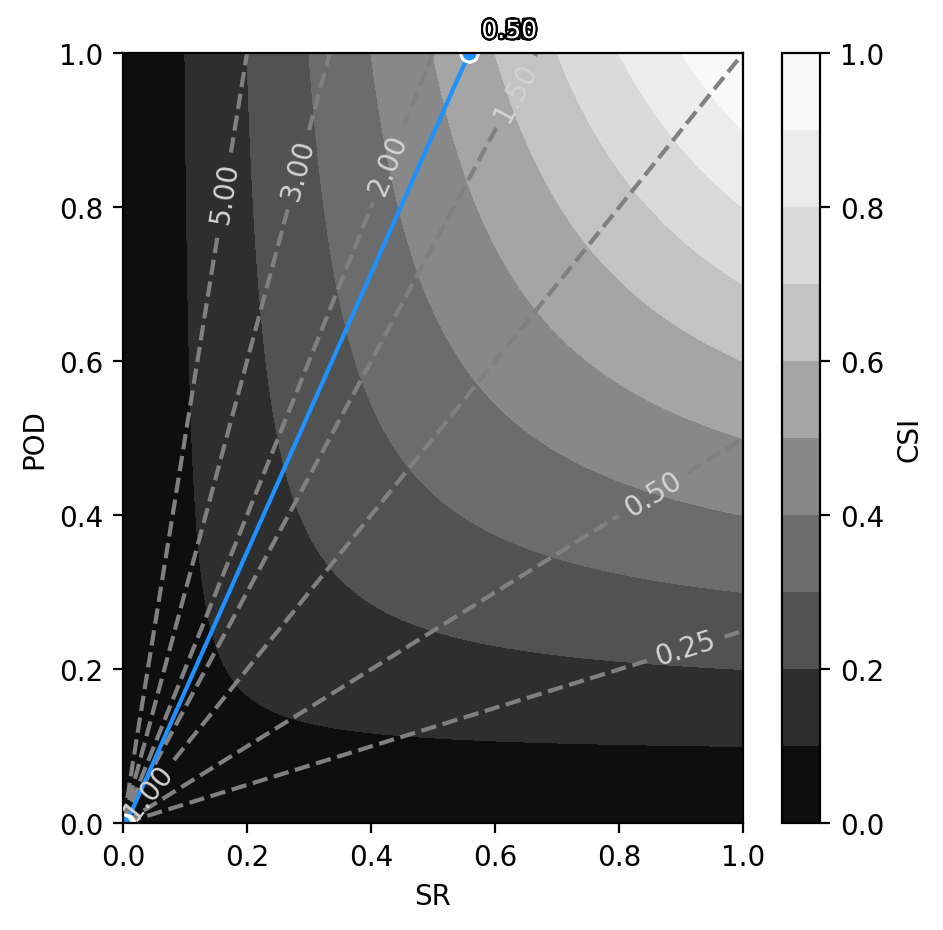

In [8]:
import matplotlib.patheffects as path_effects

# ユーティリティ関数の読み込み
import sys

sys.path.insert(1, "../scripts/")
from gewitter_functions import get_contingency_table,  get_pod, get_sr, make_performance_diagram_axis


def plot_performance_diagram(y_preds, y_valid):
    # 確率の閾値
    thresholds = np.arange(0.05, 1.05, 0.05)

    pod_list = []
    sr_list = []
    # 閾値を変えながら指標を計算
    for t in thresholds:
        y_preds_bi = np.zeros(y_preds.shape, dtype=int)
        idx = np.where(y_preds >= t)
        y_preds_bi[idx] = 1

        # 検証データのラベル（真値）と予測値のラベルから分割表を作成
        cont_table = get_contingency_table(y_preds_bi, y_valid)
        pod_list.append(get_pod(cont_table))
        sr_list.append(get_sr(cont_table))

    ax = make_performance_diagram_axis()
    ax.plot(sr_list, pod_list, "o-", color="dodgerblue", mec="w")

    for i, (sr, pod, t) in enumerate(zip(sr_list, pod_list, thresholds)):
        if sr and pod and i % 3 == 0:
            text = f"{np.round(t, 2):.2f}"
            ax.text(
                sr + 0.02,
                pod + 0.02,
                text,
                fontsize=9,
                color="white",
                path_effects=[path_effects.withStroke(linewidth=1.5, foreground="k")],
            )


plot_performance_diagram(y_preds[:, 0], valid_ds.tensors[1].numpy())

予想した通りモデルの性能は悪いです。モデルを学習させていないのである意味当然ですね。


### Step 6: モデルの学習

モデルを学習させていきましょう。バッチサイズ 32、25 エポックで学習させてみます。
過学習の確認のためにエポック毎に評価データで評価も行い損失関数を記録しています。


In [9]:
from tqdm import tqdm


# 損失関数には分類問題でよく使われるバイナリークロスエントロピー関数を利用
loss_fn = torch.nn.BCELoss()
# 最適化には RMSpropを利用
optimizer = torch.optim.RMSprop(model.parameters())

train_losses = []
val_losses = []
epochs = np.arange(0, 25)
for epoch in epochs:
    print(f"Epoch {epoch+1}/{len(epochs)}")

    # 学習
    model.train()
    train_loss = 0
    for X, y in tqdm(train_dl, total=len(train_dl)):
        # モデルの出力
        pred = model(X)
        # 損失関数の計算
        loss = loss_fn(pred, y.view(-1, 1))
        # 勾配の初期化
        optimizer.zero_grad()
        # 勾配の計算
        loss.backward()
        # パラメータ更新
        optimizer.step()
        # プロット用に損失関数を記録
        train_loss += loss.item()
    train_loss = train_loss / len(train_dl)
    train_losses.append(train_loss)

    # 評価
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X, y in valid_dl:
            # モデルの出力
            pred = model(X)
            # 損失関数の計算
            loss = loss_fn(pred, y.view(-1, 1))
            # プロット用に損失関数を記録
            valid_loss += loss.item()
    valid_loss = valid_loss / len(valid_dl)
    val_losses.append(valid_loss)

Epoch 1/25


100%|██████████| 1875/1875 [00:01<00:00, 1673.30it/s]


Epoch 2/25


100%|██████████| 1875/1875 [00:01<00:00, 1648.25it/s]


Epoch 3/25


100%|██████████| 1875/1875 [00:01<00:00, 1654.84it/s]


Epoch 4/25


100%|██████████| 1875/1875 [00:01<00:00, 1693.42it/s]


Epoch 5/25


100%|██████████| 1875/1875 [00:01<00:00, 1653.24it/s]


Epoch 6/25


100%|██████████| 1875/1875 [00:01<00:00, 1715.04it/s]


Epoch 7/25


100%|██████████| 1875/1875 [00:01<00:00, 1615.61it/s]


Epoch 8/25


100%|██████████| 1875/1875 [00:01<00:00, 1671.98it/s]


Epoch 9/25


100%|██████████| 1875/1875 [00:01<00:00, 1693.44it/s]


Epoch 10/25


100%|██████████| 1875/1875 [00:01<00:00, 1694.05it/s]


Epoch 11/25


100%|██████████| 1875/1875 [00:01<00:00, 1673.15it/s]


Epoch 12/25


100%|██████████| 1875/1875 [00:01<00:00, 1634.95it/s]


Epoch 13/25


100%|██████████| 1875/1875 [00:01<00:00, 1714.39it/s]


Epoch 14/25


100%|██████████| 1875/1875 [00:01<00:00, 1615.70it/s]


Epoch 15/25


100%|██████████| 1875/1875 [00:01<00:00, 1673.66it/s]


Epoch 16/25


100%|██████████| 1875/1875 [00:01<00:00, 1672.25it/s]


Epoch 17/25


100%|██████████| 1875/1875 [00:01<00:00, 1653.71it/s]


Epoch 18/25


100%|██████████| 1875/1875 [00:01<00:00, 1691.22it/s]


Epoch 19/25


100%|██████████| 1875/1875 [00:01<00:00, 1546.41it/s]


Epoch 20/25


100%|██████████| 1875/1875 [00:01<00:00, 1464.10it/s]


Epoch 21/25


100%|██████████| 1875/1875 [00:01<00:00, 1255.98it/s]


Epoch 22/25


100%|██████████| 1875/1875 [00:01<00:00, 1448.24it/s]


Epoch 23/25


100%|██████████| 1875/1875 [00:01<00:00, 1518.54it/s]


Epoch 24/25


100%|██████████| 1875/1875 [00:01<00:00, 1492.16it/s]


Epoch 25/25


100%|██████████| 1875/1875 [00:01<00:00, 1437.64it/s]


訓練データと評価データで求めた損失関数の変化をプロットしましょう。


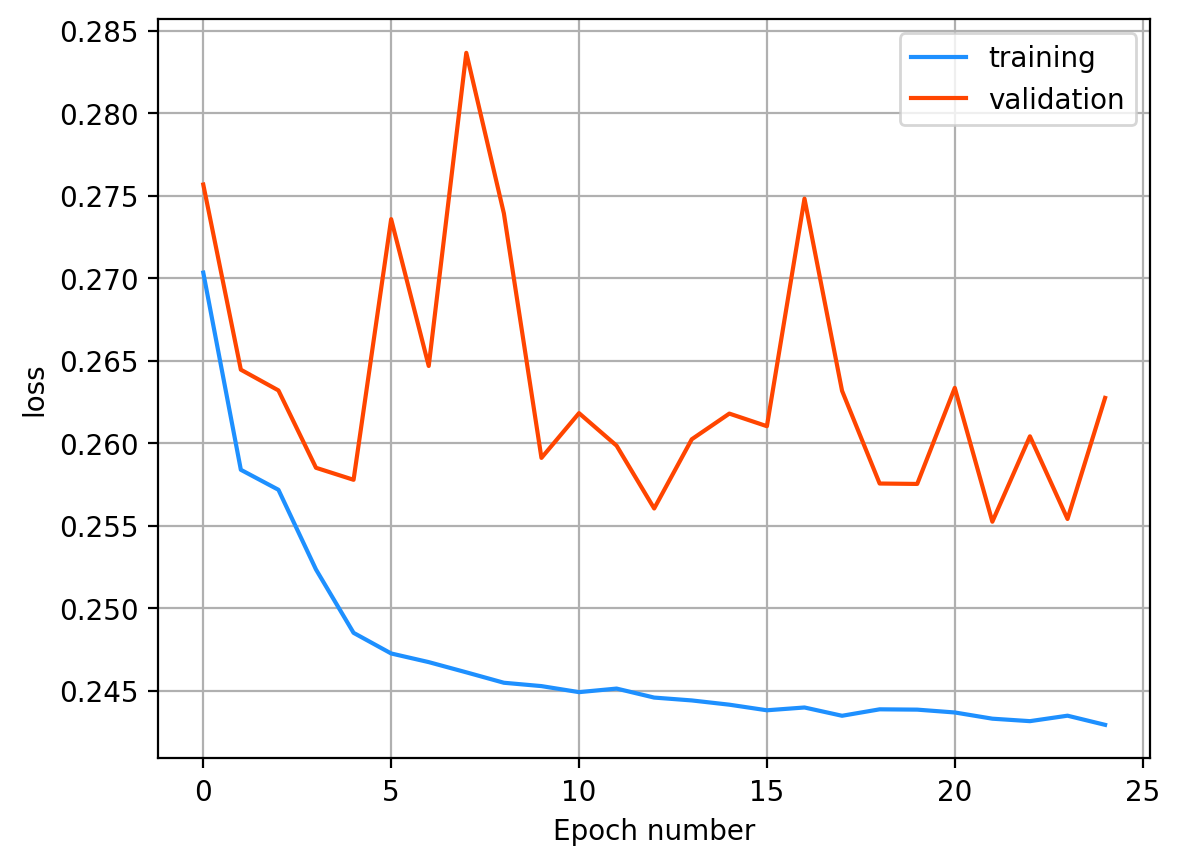

In [10]:
plt.plot(train_losses, color="dodgerblue", label="training")
plt.plot(val_losses, color="orangered", label="validation")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("loss")
plt.grid()

過学習を確認しているので絶対値はそれほど重要ではありません。
評価データは約 10 エポックで比較的変化が小さくなりエポックを重ねるにつれて損失がまた大きくなっているように見えますが、
これは過学習のシグナルと言うほどのものではなく局所的な最小値に収束してしまっているようです。


### Step 8: 学習したモデルの性能を確認する

モデルの学習が終わりました。学習したモデルで評価データから予測してみます。


(0.0, 1.0)

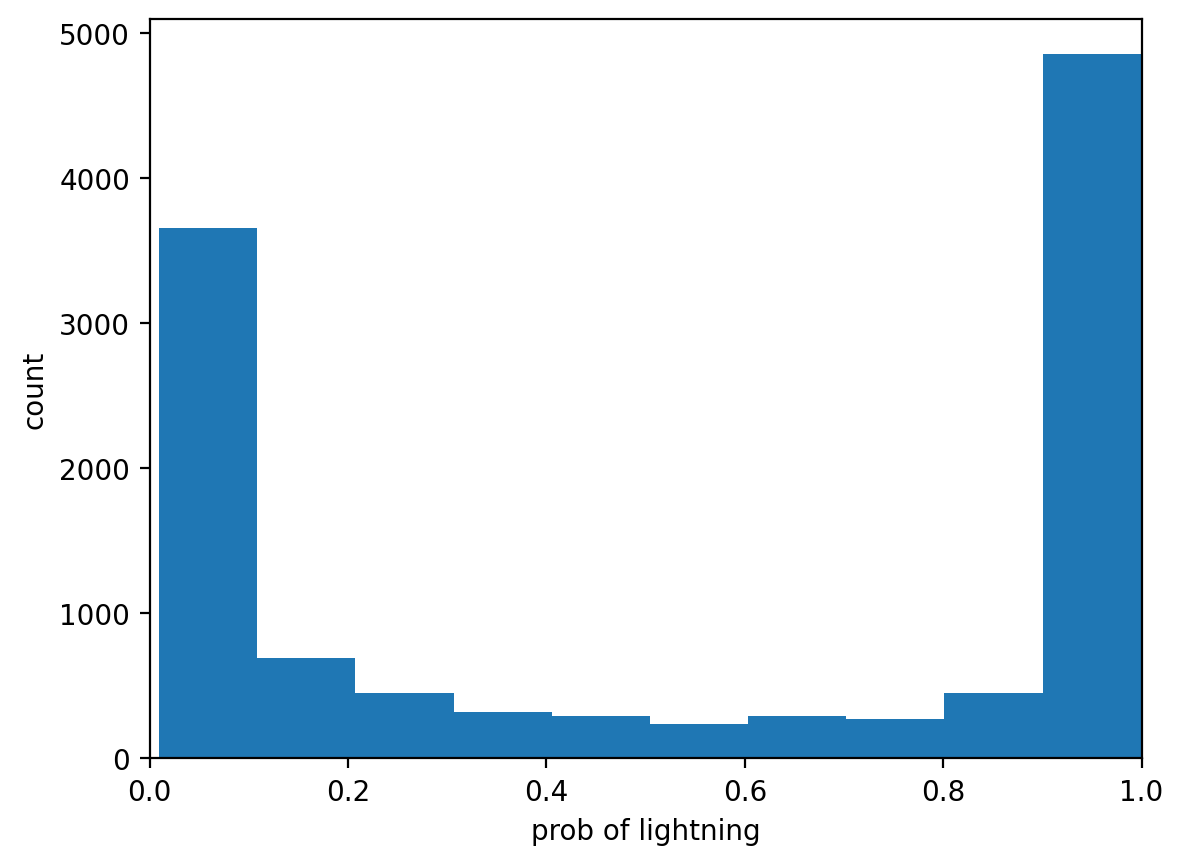

In [11]:
model.eval()
with torch.no_grad():
    y_preds = torch.cat([model(xb) for xb, _ in valid_dl]).numpy()
plt.hist(y_preds[:, 0])
plt.xlabel("prob of lightning")
plt.ylabel("count")
plt.xlim([0, 1])

パフォーマンスダイアグラムもプロットしてみましょう。


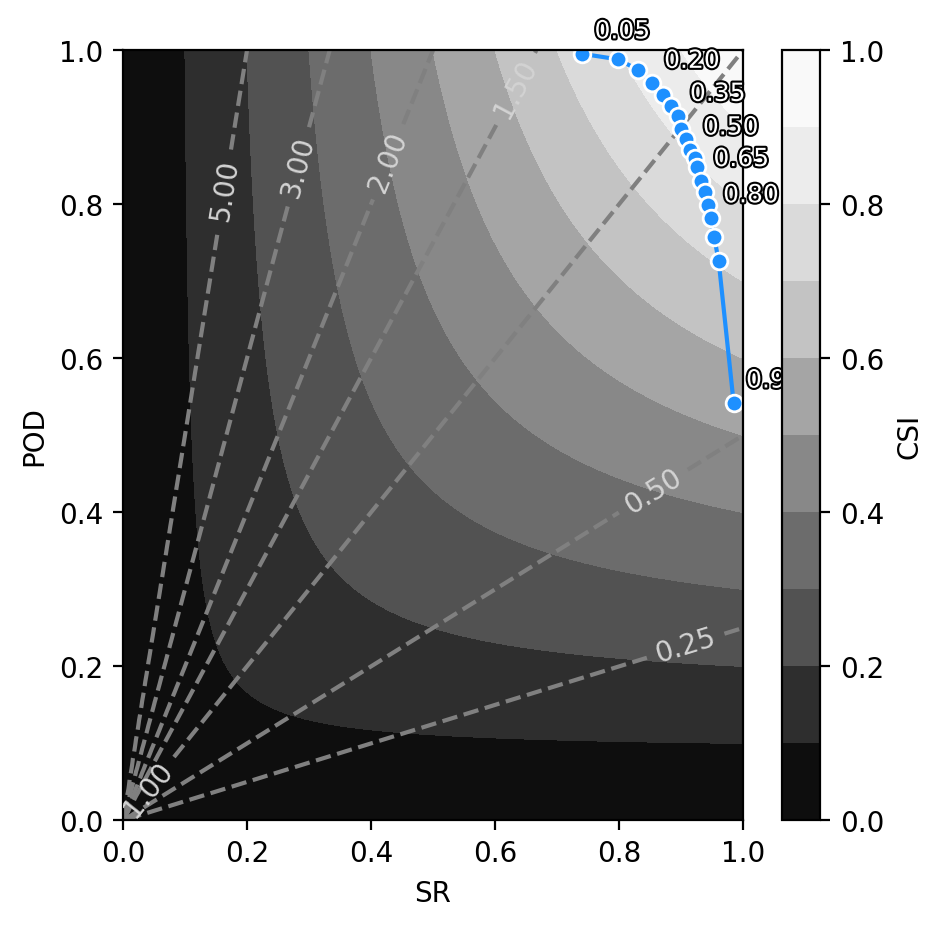

In [12]:
plot_performance_diagram(y_preds[:, 0], valid_ds.tensors[1].numpy())

学習前に比べかなりよくなりました。単純なニューラルネットワークでもこのようによい性能を得ることができました。
これは、前のノートで赤外輝度温度のみを特徴量とした場合でも 80%の正解率だったことからも問題設定が比較的簡単であるからだと思われます。
パフォーマンスダイアグラムの各点はモデルが出力した確率値からラベル付けする閾値を変えたとき性能を表します。
今回のモデルでは閾値が約 36%の時に最も CSI が大きくバイアスが小さくなっています。
このことからモデルの出力する確率値を閾値 36%で発雷あり、発雷なしとするのが最も最適化された予測であるといえます。

このモデルのネットワークは非常に小さいので各層の学習済みの重みとバイアスパラメータを見てみましょう。
パラメータの値そのものは私たちにとってはあまり意味がありませんが、モデルの各層が機能しているかを確認するにはよい方法です。


In [13]:
# 入力層 nn.Linear(in_features=36, out_features=2)
print(model[0].weight, model[0].bias)

Parameter containing:
tensor([[-0.0485,  0.3519,  0.0168,  0.3413, -0.1679, -0.2856,  0.0231, -0.0197,
         -0.2057,  0.3515,  0.3853, -0.1661, -0.0694,  0.3092, -0.2197, -0.2338,
         -0.4837, -0.3284,  0.2194,  0.0677, -0.1683,  0.1295, -0.1513, -0.2169,
         -0.0986, -0.2276, -0.1329,  0.5174,  0.1952,  0.2426, -0.2498, -0.1388,
         -0.0080,  0.1970, -0.4161, -0.2641],
        [-2.7764, -2.0973, -2.6493, -0.0477,  0.6211,  1.1040,  0.8457, -1.0969,
          2.2722, -1.0902,  2.3608,  0.9079,  0.6944, -0.5912, -2.2698,  1.0413,
         -0.7669,  1.1125,  0.3924,  0.5842, -0.7571, -0.4003, -0.1884,  0.5025,
         -1.1631,  0.3455,  0.5807,  3.8013,  3.6536,  2.2442, -1.1446,  2.2661,
         -1.6755, -0.0621, -0.1305,  0.9020]], requires_grad=True) Parameter containing:
tensor([-0.1202, -3.7269], requires_grad=True)


In [14]:
# 中間層 nn.Linear(in_features=2, out_features=2)
print(model[2].weight, model[2].bias)

Parameter containing:
tensor([[-0.7806, -0.4035],
        [ 0.3304,  0.3992]], requires_grad=True) Parameter containing:
tensor([ 5.3645, -0.0290], requires_grad=True)


### Step 9: 学習済みモデルの保存

モデルを再利用するときに再学習を毎回するのは大変です。PyTorch の学習済みモデルを保存しましょう。


In [15]:
from pathlib import Path

save_dir = Path("../datasets/models/neural_nets_from_notebooks")
save_file = save_dir / "MyFirstNN.pth"
if not save_dir.exists():
    save_dir.mkdir(parents=True)

torch.save(model, save_file)  # モデルの構造定義ごと保存する

### Step 13: モデルの読み込み

保存したモデルを読み込んで同じ図を作成してみます。


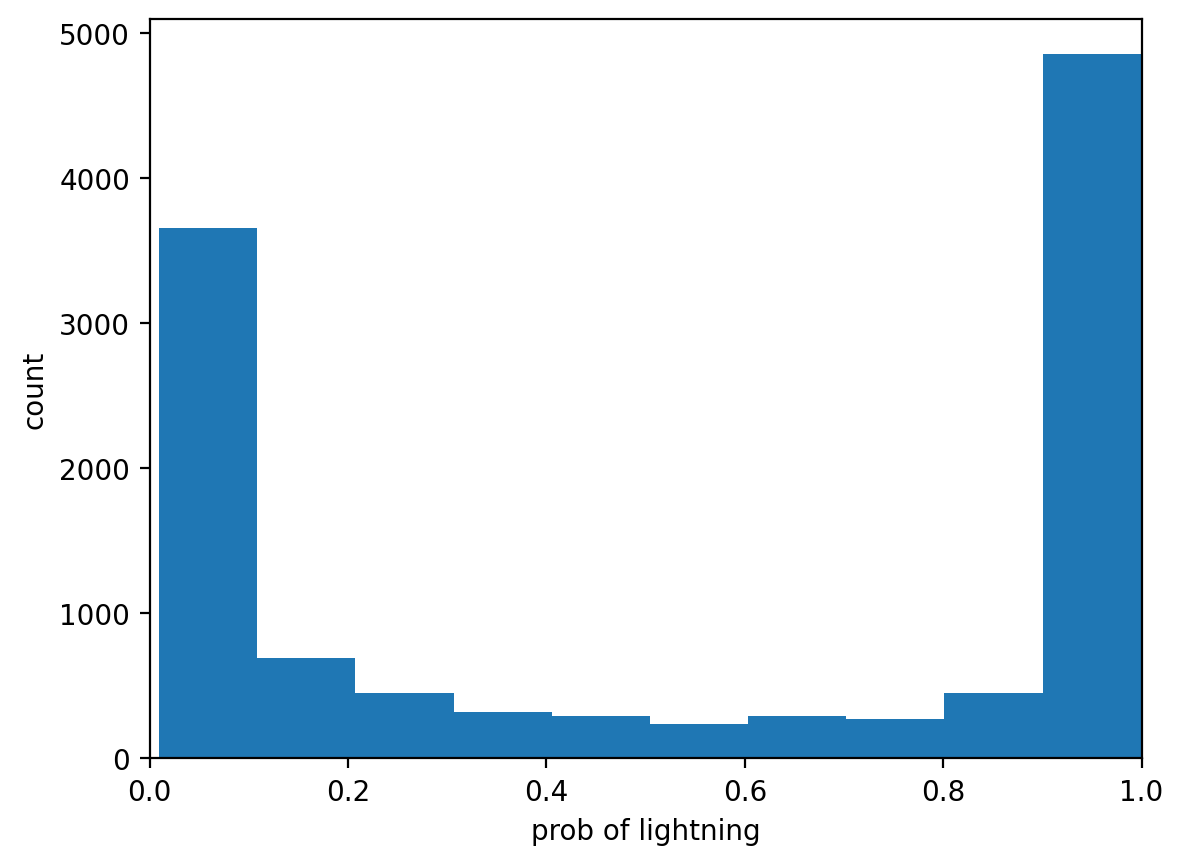

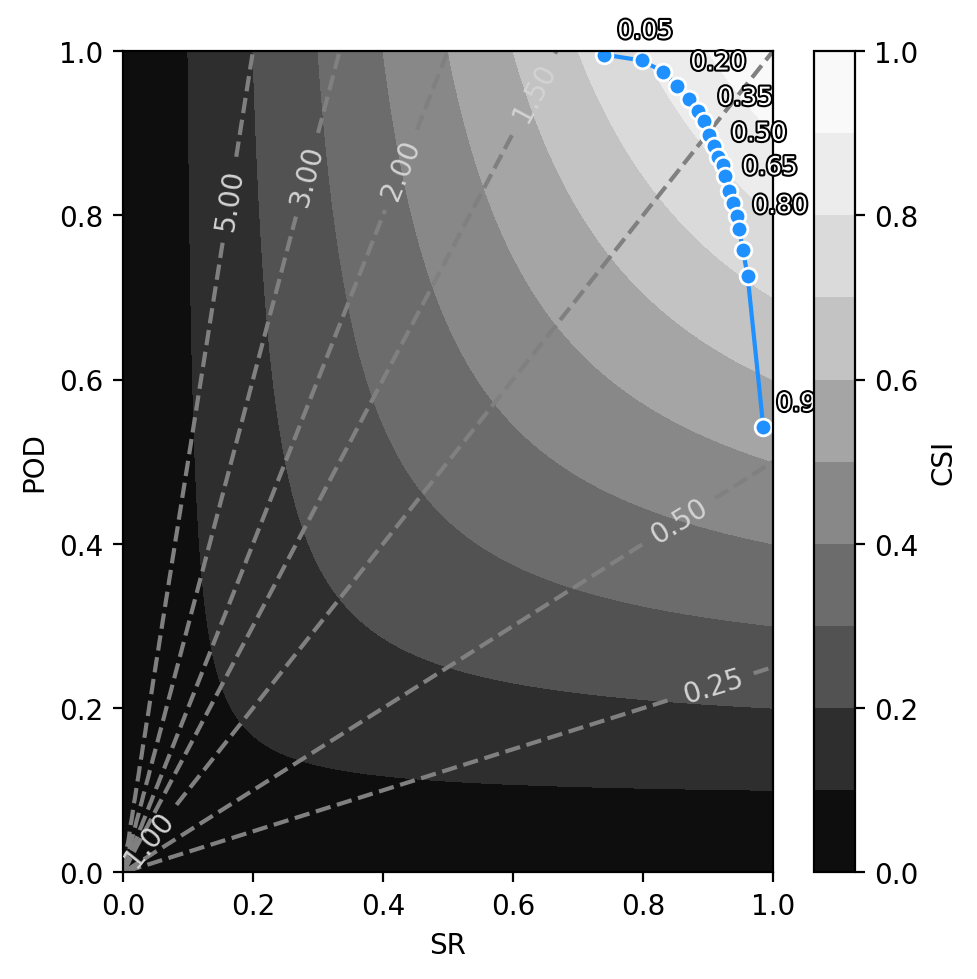

In [16]:
from pathlib import Path

# 読み込み
save_dir = Path("../datasets/models/neural_nets_from_notebooks")
save_file = save_dir / "MyFirstNN.pth"
if not save_dir.exists():
    save_dir.mkdir(parents=True)

model = torch.load(save_file)

model.eval()
with torch.no_grad():
    y_preds = torch.cat([model(xb) for xb, _ in valid_dl])

plt.hist(y_preds[:, 0])
plt.xlabel("prob of lightning")
plt.ylabel("count")
plt.xlim([0, 1])

# パフォーマンスダイアグラム
plot_performance_diagram(y_preds[:, 0].numpy(), valid_ds.tensors[1].numpy())

plt.tight_layout()

モデルのパラメータだけ保存して読み込みたい場合は `model.state_dict()` を保存し `model.load_state_dict()` で読み込みます。
[公式チュートリアル](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html)で確認してみましょう。
